In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import YouTubeVideo
import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.rcParams['axes.color_cycle'] = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', 
                                    u'#9467bd', u'#8c564b', u'#e377c2']

df1 = pd.read_csv('Titanic/Dataset/train.csv')
df2 = pd.read_csv('Titanic/Dataset/test.csv')
df1['Set'] = 'train'
df2['Set'] = 'test'

df=df1.append(df2)
# df=df.reset_index()
# df.info()
# df.head()

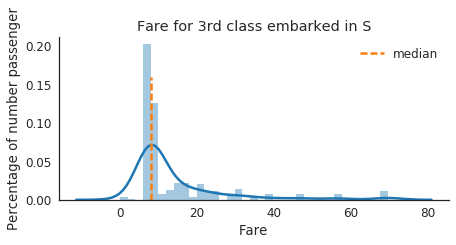

In [50]:
df['Embarked'] = df['Embarked'].fillna('S') 
a = df['Fare'].loc[(df['Pclass']==3) & (df['Embarked']=='S')]
plt.figure(figsize=(7,3))
sns.distplot(a.dropna(), color='C0')
plt.plot([a.median(), a.median()], [0, 0.16], '--', color='C1')

df['Fare'] = df['Fare'].fillna(a.median())
sns.despine(bottom=0, left=0)
plt.title('Fare for 3rd class embarked in S')
plt.xlabel('Fare')
plt.ylabel('Percentage of number passenger')
plt.legend(['median'])
plt.show()

In [51]:
# Clean up and feature engineering

# Label Survived for plot
df['Survived'] = df['Survived'].replace([0, 1], ['no', 'yes']) 

# Label Sex for plot
df['Sex'] = df['Sex'].replace([0, 1], ['male', 'female']) 

# Transform Fare to today's US dollar, for fun
df['Fare'] = df['Fare']*108*1.3 #historic gbp to current gbp to current usd

# Get personal title from Name, merge rare titles
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split(' ')[1])
toreplace = ['Jonkheer.', 'Ms.', 'Mlle.', 'Mme.', 'Capt.', 'Don.', 'Major.', 
             'Col.', 'Sir.', 'Dona.', 'Lady.', 'the']
replacewith = ['Master.', 'Miss.', 'Miss.', 'Mrs.', 'Sir.', 'Sir.', 'Sir.',
              'Sir.', 'Sir.', 'Lady.', 'Lady.', 'Lady.']
df['Title'] = df['Title'].replace(toreplace, replacewith)

# Get family names
df['FamName'] = df['Name'].apply(lambda x: x.split(',')[0])

# Get family sizes based on Parch and SibSp, classify as single/small/large
df['FamSize'] = df['Parch'] + df['SibSp'] + 1
df['FamSize2'] = pd.cut(df['FamSize'], [0, 1, 4, 11], labels=['single', 'small', 'large'])

# Get group sizes based on Ticket, classify as single/small/large
df['GrpSize'] = df['Ticket'].replace(df['Ticket'].value_counts())
df['GrpSize2'] = pd.cut(df['GrpSize'], [0, 1, 4, 11], labels=['single', 'small', 'large'])

# Get Deck from Cabin letter
def getdeck(cabin):
    if not pd.isnull(cabin) and cabin[0] in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        return cabin[0]
    else:
        return 'X'    
    
df['Deck'] = df['Cabin'].apply(getdeck)

# Get a rough front/mid/back location on the ship based on Cabin number
'''
A front
B until B49 is front, rest mid
C until C46 is front, rest mid
D until D50 is front, rest back
E until E27 is front, until E76 mid, rest back
F back
G back
Source: encyclopedia-titanica.org/titanic-deckplans/
'''
def getfmb(cabin):
    
    if not pd.isnull(cabin) and len(cabin)>1:
        if (cabin[0]=='A'
            or cabin[0]=='B' and int(cabin[1:4])<=49
            or cabin[0]=='C' and int(cabin[1:4])<=46
            or cabin[0]=='D' and int(cabin[1:4])<=50
            or cabin[0]=='E' and int(cabin[1:4])<=27):
            return 'front'
        
        elif (cabin[0]=='B' and int(cabin[1:4])>49
            or cabin[0]=='C' and int(cabin[1:4])>46
            or cabin[0]=='E' and int(cabin[1:4])>27 and int(cabin[1:4])<=76):
            return 'mid'

        elif (cabin[0]=='F'
           or cabin[0]=='G'
           or cabin[0]=='D' and int(cabin[1:4])>50):
            return 'back'
        
        else:
            return 'unknown'
    else:
        return 'unknown'        
    
df['CabinLoc'] = df['Cabin'].apply(getfmb)

dfstrings = df.copy()
df.head()


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Set,Sex,...,Survived,Ticket,Title,FamName,FamSize,FamSize2,GrpSize,GrpSize2,Deck,CabinLoc
0,22.0,NaN,S,1017.90000,"Braund, Mr. Owen Harris",0,1,3,train,male,...,no,A/5 21171,Mr.,Braund,2,small,1,single,X,unknown
1,38.0,C85,C,10008.17532,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,train,female,...,yes,PC 17599,Mrs.,Cumings,2,small,2,small,C,mid
2,26.0,NaN,S,1112.67000,"Heikkinen, Miss. Laina",0,3,3,train,female,...,yes,STON/O2. 3101282,Miss.,Heikkinen,1,single,1,single,X,unknown
3,35.0,C123,S,7455.24000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,train,female,...,yes,113803,Mrs.,Futrelle,2,small,2,small,C,mid
4,35.0,NaN,S,1130.22000,"Allen, Mr. William Henry",0,5,3,train,male,...,no,373450,Mr.,Allen,1,single,1,single,X,unknown


In [52]:
# Factorize the string features

df['CabinLoc'] = df['CabinLoc'].replace(['unknown', 'front', 'mid', 'back'], range(4))

df['Deck'] = df['Deck'].replace(['X', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], range(8))

df['GrpSize2'] = df['GrpSize2'].astype(str) #convert from category dtype
df['GrpSize2'] = df['GrpSize2'].replace(['single', 'small', 'large'], range(3))

df['FamSize2'] = df['FamSize2'].astype(str) #convert from category dtype
df['FamSize2'] = df['FamSize2'].replace(['single', 'small', 'large'], range(3))

df['Title'] = df['Title'].replace(df['Title'].unique(), range(8))

df['Embarked'] = df['Embarked'].replace(['S', 'C', 'Q'], range(3))

df['Sex'] = df['Sex'].replace(['male', 'female'], range(2)) 

df['Survived'] = df['Survived'].replace(['no', 'yes'], range(2)) 

dfnum = df.copy() # save df containing factorized features to use for subsequent analysis
dfnum.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Set,Sex,...,Survived,Ticket,Title,FamName,FamSize,FamSize2,GrpSize,GrpSize2,Deck,CabinLoc
0,22.0,NaN,0,1017.90000,"Braund, Mr. Owen Harris",0,1,3,train,0,...,0.0,A/5 21171,0,Braund,2,1,1,0,0,0
1,38.0,C85,1,10008.17532,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,train,1,...,1.0,PC 17599,1,Cumings,2,1,2,1,3,2
2,26.0,NaN,0,1112.67000,"Heikkinen, Miss. Laina",0,3,3,train,1,...,1.0,STON/O2. 3101282,2,Heikkinen,1,0,1,0,0,0
3,35.0,C123,0,7455.24000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,train,1,...,1.0,113803,1,Futrelle,2,1,2,1,3,2
4,35.0,NaN,0,1130.22000,"Allen, Mr. William Henry",0,5,3,train,0,...,0.0,373450,0,Allen,1,0,1,0,0,0


Mean train: 29.5949234694
Std predtrain: 7.43156232314
RMSE predtrain: 12.1700107869
Mean test: 29.7096713791
Std predtest: 7.63790753566
RMSE predtest: 12.5424798989
3.75211907362 44.1413626457


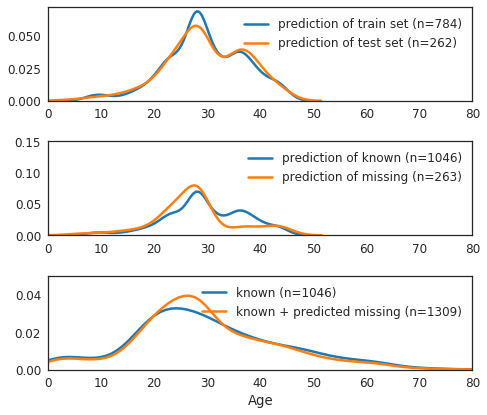

In [53]:
# Multiple linear regression modeling of Age
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

feats = ['Sex', 'Embarked', 'Pclass', 'Fare', 'Title', 'Parch', 'SibSp', 'FamSize', 'FamSize2', 
         'GrpSize', 'GrpSize2', 'Deck', 'CabinLoc' ]

dffeats = df[feats][df['Age'].notnull()]
dfresp = df['Age'][df['Age'].notnull()]
dfmiss = df[feats][df['Age'].isnull()]

X_train, X_test, y_train, y_test = train_test_split(dffeats, dfresp, test_size=0.25, random_state=100)

lm = LinearRegression()
lm.fit(X_train, y_train )

y_predtrain = lm.predict(X_train)
print('Mean train: ' + str(np.mean(y_predtrain)))
print('Std predtrain: ' + str(np.std(y_predtrain)))
print('RMSE predtrain: ' + str(np.sqrt(metrics.mean_squared_error(y_train, y_predtrain))))

y_predtest = lm.predict(X_test)
print('Mean test: ' + str(np.mean(y_predtest)))
print('Std predtest: ' + str(np.std(y_predtest)))
print('RMSE predtest: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_predtest))))

pred1 = lm.predict(dffeats)
pred2 = lm.predict(dfmiss)
print(pred2.min(), pred2.max())

# Plots for Age regression
fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[7,6])

sns.distplot(y_predtrain, hist=False, label='prediction of train set (n=784)', ax=ax1)
sns.distplot(y_predtest, hist=False, label='prediction of test set (n=262)', ax=ax1)
ax1.set_xlim([0, 80])

sns.distplot(pred1, hist=False, label='prediction of known (n=1046)', ax=ax2)
sns.distplot(pred2, hist=False, label='prediction of missing (n=263)', ax=ax2)
ax2.set_xlim([0, 80])
ax2.set_ylim([0, 0.15])

sns.distplot(dfresp, hist=False, label='known (n=1046)', ax=ax3)
sns.distplot(dfresp.values.tolist() + pred2.tolist(), hist=False, label='known + predicted missing (n=1309)', ax=ax3)
ax3.set_xlim([0, 80])
ax3.set_ylim([0, 0.05])

fig.tight_layout()
# sns.despine(bottom=0, left=0)


In [72]:
# Updating the dataframe (strings version) with Age related features
df = dfstrings

# df['Age'].loc[df['Age'].isnull()] = pred2
# df.head()

# # Classify age groups
df['AgeGrp'] = pd.cut(df['Age'], [0, 12, 20, 200], labels = ['child', 'teen', 'adult'])

# df.head()
# Classify age decade
df['AgeDec'] = pd.cut(df['Age'], range(0,90,10), labels=range(8))
df['AgeDec'] = df['AgeDec'].astype(int)


# Classify male/female/child
df['PersonType'] = df['Sex']
df.loc[df['Age']<12,'PersonType'] = 'child'

# Updating the dataframe (numbers version) with Age related features
dfnum['Age'] = df['Age']

dfnum['AgeGrp'] = df['AgeGrp'].astype(str) #convert from category dtype
dfnum['AgeGrp'] = dfnum['AgeGrp'].replace(['child', 'teen', 'adult'], range(3))

dfnum['AgeDec'] = df['AgeDec']

dfnum['PersonType'] = df['PersonType'].replace(['male', 'female', 'child'], range(3)) 

dfnum.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Set,Sex,...,FamName,FamSize,FamSize2,GrpSize,GrpSize2,Deck,CabinLoc,AgeGrp,AgeDec,PersonType
0,22.0,NaN,0,1017.90000,"Braund, Mr. Owen Harris",0,1,3,train,0,...,Braund,2,1,1,0,0,0,2,2,0
1,38.0,C85,1,10008.17532,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,train,1,...,Cumings,2,1,2,1,3,2,2,3,1
2,26.0,NaN,0,1112.67000,"Heikkinen, Miss. Laina",0,3,3,train,1,...,Heikkinen,1,0,1,0,0,0,2,2,1
3,35.0,C123,0,7455.24000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,train,1,...,Futrelle,2,1,2,1,3,2,2,3,1
4,35.0,NaN,0,1130.22000,"Allen, Mr. William Henry",0,5,3,train,0,...,Allen,1,0,1,0,0,0,2,3,0


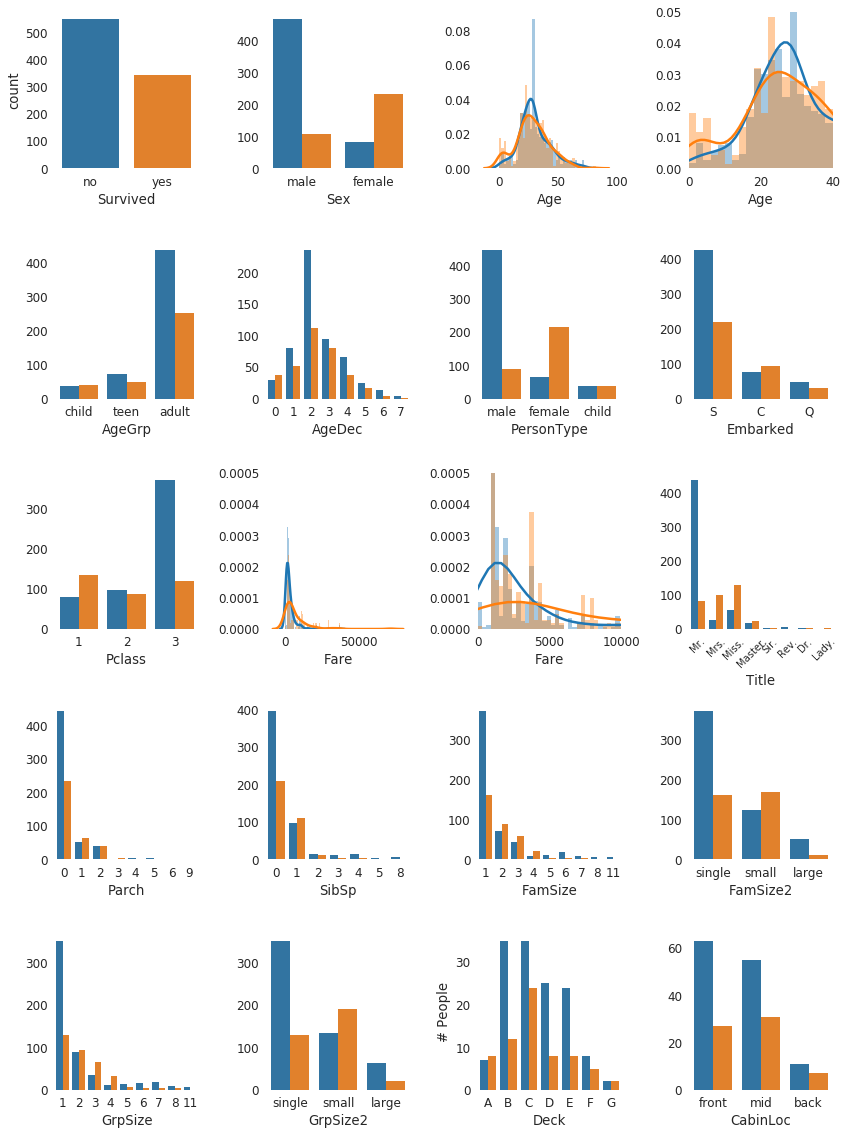

In [92]:
fig, axes = plt.subplots(5,4, figsize=[12,16])
axes = axes.ravel()

axnr = 0

for i in ['Survived', 'Sex', 'Age', 'Age', 'AgeGrp', 'AgeDec', 'PersonType', 'Embarked', 'Pclass', 
          'Fare', 'Fare', 'Title', 'Parch', 'SibSp', 'FamSize', 'FamSize2', 'GrpSize', 'GrpSize2', 
          'Deck', 'CabinLoc' ]: 
    sns.countplot(x=i, hue='Survived', data=df, ax=axes[axnr])
    axes[axnr].set(xlabel=i, ylabel="")
    axes[axnr].legend().set_visible(False)
    axnr += 1
    
axes[0].cla() #clear and replace plot
sns.countplot('Survived', data=df, ax=axes[0])
axes[0].set(xlabel='Survived', ylabel="count")

axes[2].cla()
sns.distplot(df['Age'][df['Survived']=='no'], ax=axes[2], bins=range(0, 100, 2))
sns.distplot(df['Age'][df['Survived']=='yes'], ax=axes[2], bins=range(0, 100, 2))

axes[3].cla()
sns.distplot(df['Age'][df['Survived']=='no'], ax=axes[3], bins=range(0, 100, 2))
sns.distplot(df['Age'][df['Survived']=='yes'], ax=axes[3], bins=range(0, 100, 2))
axes[3].set(xlim=[0,40], ylim=[0,0.05])

axes[9].cla()
sns.distplot(df['Fare'][df['Survived']=='no'], ax=axes[9], bins=range(0, 72000, 300))
sns.distplot(df['Fare'][df['Survived']=='yes'], ax=axes[9], bins=range(0, 72000, 300))
axes[9].set(ylim=[0,0.0005])

axes[10].cla()
sns.distplot(df['Fare'][df['Survived']=='no'], ax=axes[10], bins=range(0, 72000, 300))
sns.distplot(df['Fare'][df['Survived']=='yes'], ax=axes[10], bins=range(0, 72000, 300))
axes[10].set(xlim=[0,10000], ylim=[0,0.0005])

axes[11].set_xticklabels(axes[11].get_xticklabels(), rotation = 45, size='x-small', ha="center")

axes[18].cla()
sns.countplot(x='Deck', hue='Survived', data=df[df['Deck'] != 'X'], ax=axes[18], order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
axes[18].set(xlabel='Deck', ylabel="# People")
axes[18].legend().set_visible(False)

axes[19].cla()
sns.countplot(x='CabinLoc', hue='Survived', data=df[df['CabinLoc'] != 'unknown'], 
              ax=axes[19], order=['front', 'mid', 'back'])
axes[19].set(xlabel='CabinLoc', ylabel="")
axes[19].legend().set_visible(False)    


fig.tight_layout()
sns.despine(bottom=1, left=1)

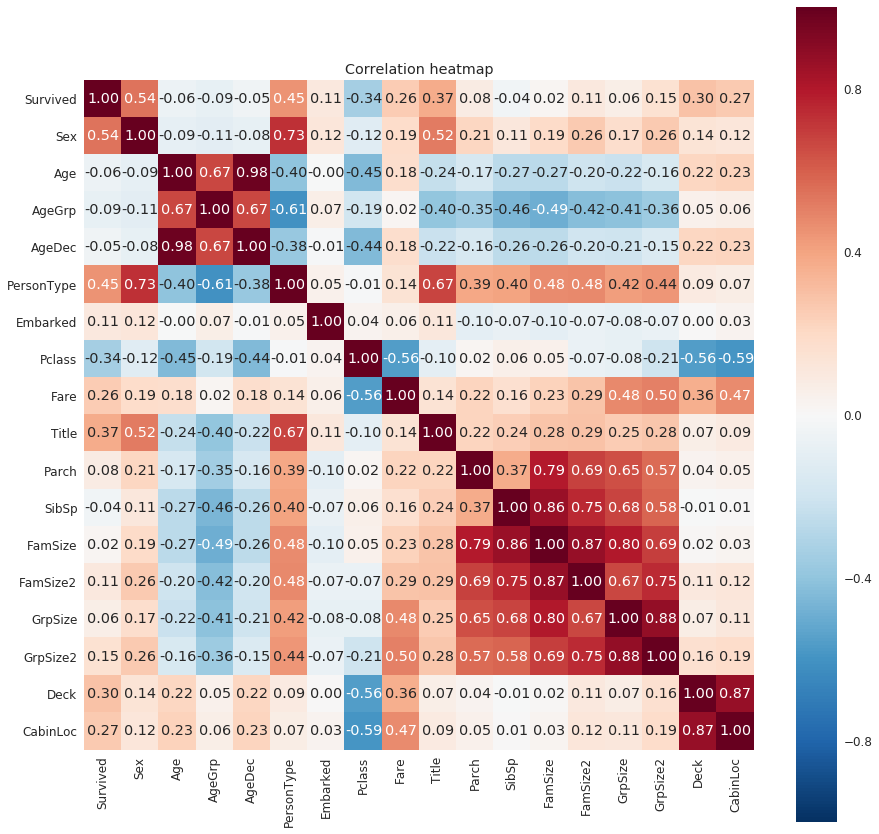

In [93]:
df = dfnum
fig = plt.subplots(figsize=[15, 15])

sns.heatmap(df[['Survived', 'Sex', 'Age', 'AgeGrp', 'AgeDec', 'PersonType', 'Embarked', 'Pclass', 
                'Fare', 'Title', 'Parch', 'SibSp', 'FamSize', 'FamSize2', 'GrpSize', 'GrpSize2', 
                'Deck', 'CabinLoc']].corr(), 
            annot=True, fmt=".2f", square=1, cmap="RdBu_r", vmin=-1, vmax=1)
plt.title('Correlation heatmap')
plt.show()

KeyError: 'AgeDec'

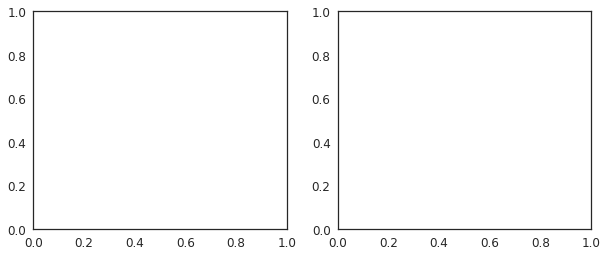

In [113]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=[10,4])
x='AgeDec'
y='Survived'
df['Grpcount'] = df.groupby([x, y]).transform('count')['index'].values


# df['Grpcount'] = df.groupby([x, y]).transform('count')['index'].values



df['Grpmean'] = df.groupby([x]).transform('mean')[y].values
sns.regplot(x, y, data=df, scatter_kws={'s': df['Grpcount']*7}, line_kws={'color':'C2'}, ax=ax1)
ax1.plot(df[x], df['Grpmean'], 'o', color='C3')
ax1.set_ylim([-0.15, 1.1])

x='Embarked'
y='Pclass'
df['Grpcount'] = df.groupby([x, y]).transform('count')['index'].values
df['Grpmean'] = df.groupby([x]).transform('mean')[y].values
sns.regplot(x, y, data=df, scatter_kws={'s': df['Grpcount']*7}, line_kws={'color':'C2'}, ax=ax2, color='C0')
ax2.plot(df[x], df['Grpmean'], 'o', color='C3')
ax2.set_ylim([0.7, 3.4])
ax2.set_xlim([-0.4, 2.3])
ax2.set_xticks(range(3))

fig.tight_layout()
sns.despine(bottom=0, left=0)
plt.show()

In [114]:
# Split into train/test
feats = ['Sex', 'Age', 'AgeGrp', 'AgeDec', 'PersonType', 'Embarked', 'Pclass', 'Fare', 'Title',
         'Parch', 'SibSp', 'FamSize', 'FamSize2', 'GrpSize', 'GrpSize2', 'Deck', 'CabinLoc'] 

dff = df[['PassengerId', 'Set', 'Survived'] + feats]

train = dff[dff['Set'] == 'train'].drop('Set', 1)
test = dff[dff['Set'] == 'test'].drop('Set', 1)

trainx = train[feats].values
trainy = train['Survived'].values.astype(int)

testx = test[feats].values



KeyError: "['PassengerId' 'Set' 'Survived' 'Sex' 'Age' 'AgeGrp' 'AgeDec' 'PersonType'\n 'Embarked' 'Pclass' 'Fare' 'Title' 'Parch' 'SibSp' 'FamSize' 'FamSize2'\n 'GrpSize' 'GrpSize2' 'Deck' 'CabinLoc'] not in index"

In [112]:
zscore = lambda x: (x - x.mean()) / x.std() # Note that it does not reference anything outside of 'x' and for transform 'x' is one column.
df_2 = df.groupby('A').transform(zscore)
df_2.head(10)

,C,D
0,-1.002525,0.475699
1,0.755159,-1.069829
2,1.580224,0.741309
3,0.378927,0.158617
4,-0.630815,-0.638528
5,-1.134085,0.911212
6,0.248478,-1.440138
7,-0.195362,0.861658
